# Modelling using value of R0

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [1330]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn import tree
from scipy.stats import norm
from scipy.stats import t
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree

from sklearn.metrics import fbeta_score, make_scorer
import seaborn as sns
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor
import shap

import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Read file and prepare data 

In [1331]:
#df = pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed.csv')
#df = pd.read_csv('/Users/lucas_botella/Downloads/cluster_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/cluster_per_deaths_for_model.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL.csv')
del df['Unnamed: 0']
df['deaths_prev_18']
del df['Excess mortality P-scores, all ages']
del df['Excess mortality P-scores, all ages Prev 7 days']
df['Excess mortality P-scores, all ages Prev 18 days']
del df['Excess mortality P-scores, all ages Prev 36 days']
del df['deaths_prev_36']
df['deaths_prev_7']
df['average_deaths_2015_2019_all_ages']
df['deaths']
del df['month']
#del df['life_expectancy']
#del df['%df_population_gr_65']
#del df['UN Population Division (Median Age) (2017)']
del df['number_of_arrivals']
del df['doctors_per_1000']
del df['nurses_per_1000']
del df['beds_per_1000']
#del df['Holiday']
#del df['residential']
#del df['urban_population']
#del df['%youth_unemployment_total']
#del df['income_support']
#del df['debt_relief']

In [1332]:
df=df[~df.isin([np.inf, -np.inf]).any(1)]

In [1333]:
df=df[(df['Excess mortality P-scores, all ages Prev 18 days']>1)]
df=df[(np.abs(df['R0'])<7)]
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', 'life_expectancy', '%df_population_gr_65',
       'UN Population Division (Median Age) (2017)',
       'Excess mortality P-scores, all ages Prev 18 days',
       'average_deaths_2015_2019_all_ages', 'deaths_prev_7', 'deaths_prev_18',
       'deaths', 'accumulated', 'R0'],
      dtype='object')

In [1334]:
df.sort_values('R0')

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,life_expectancy,%df_population_gr_65,UN Population Division (Median Age) (2017),"Excess mortality P-scores, all ages Prev 18 days",average_deaths_2015_2019_all_ages,deaths_prev_7,deaths_prev_18,deaths,accumulated,R0
1287,LUX,2020-05-10,-80.795857,-42.387714,29.550857,-68.673571,-26.469286,-68.102143,2.0,1.000000,...,82.295122,14.274949,39.700001,12.66,89.80,-3.502200,11.368680,23.725160,0.017359,-6.774359
1261,LTU,2020-11-08,-23.265286,20.816571,0.204286,-12.000000,24.551000,-8.347143,2.0,2.000000,...,75.680488,20.158413,43.500000,6.07,934.20,-24.849720,56.705940,166.941540,0.034890,-6.718045
1564,NOR,2020-09-13,-1.673571,7.571286,1.694000,-19.306143,111.122571,-21.877714,2.0,2.000000,...,82.758537,17.272666,39.700001,4.02,722.80,-12.793560,29.056560,78.134680,0.008865,-6.107345
1257,LTU,2020-10-11,-16.836714,21.449000,-4.897857,-3.102143,115.408286,-9.612286,2.0,2.000000,...,75.680488,20.158413,43.500000,2.07,755.65,-6.951980,15.641955,40.653970,0.028796,-5.847826
1141,ITA,2020-05-31,-64.265429,-33.857000,19.265429,-59.510286,-37.408000,-44.102000,2.0,2.000000,...,83.346341,23.012137,47.900002,8.31,14291.80,45.733760,1187.648580,-255.823220,0.088519,-5.593750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,LUX,2020-05-31,-65.551143,-37.040857,22.448857,-55.346857,-10.979571,-53.265286,2.0,1.857143,...,82.295122,14.274949,39.700001,26.42,89.80,1.876820,23.725160,12.715680,0.023100,6.775120
1098,ISR,2020-08-02,-23.632714,0.000000,9.020429,-17.244857,12.408286,-24.551143,1.0,2.000000,...,82.802439,12.208674,30.600000,10.23,967.35,31.825815,98.959905,216.879870,0.014353,6.814590
1986,TWN,2020-11-15,-8.265286,2.918286,0.122571,-6.897857,-6.163286,2.285857,2.0,3.000000,...,NaN,NaN,42.200001,1.80,3934.35,25.179840,70.818300,172.324530,NaN,6.843750
1958,TWN,2020-05-03,-14.673286,1.224571,4.142714,-24.020429,-10.387857,1.612429,2.0,2.000000,...,NaN,NaN,42.200001,1.65,3925.45,21.589975,64.769925,148.774555,NaN,6.890909


df=df[['Code', 'Date', 'retail_and_recreation','restriction_gatherings', 'urban_population', 'workplace_closures', 'temp', 'accumulated', 'R0' ]]

df['R0_dummy_pred']=(df['R0_prev18']- (df['accumulated']*df['R0_prev18']/100))**2
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
del df['R0_prev18']

## Feature Engineering

df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)

df['movement']=df['number_of_arrivals']/((df['international_travel_controls']+df['restrictions_internal_movements'])/2)
del df['international_travel_controls']
del df['restrictions_internal_movements']
del df['number_of_arrivals']
df['tracking']=(df['testing_policy']+df['contact_tracing'])/2
del df['testing_policy']
del df['contact_tracing']
df['economic_support']=(df['debt_relief']+df['income_support'])/2
del df['debt_relief']
del df['income_support']
df['%youth_unemployment_total']=df['%youth_unemployment_total']*df['retail_and_recreation']
#df['days_from_beginning']= (pd.to_datetime(df['Date']) -pd.Timestamp(2020, 3, 1)).dt.days
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
df

In [1335]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', 'life_expectancy', '%df_population_gr_65',
       'UN Population Division (Median Age) (2017)',
       'Excess mortality P-scores, all ages Prev 18 days',
       'average_deaths_2015_2019_all_ages', 'deaths_prev_7', 'deaths_prev_18',
       'deaths', 'accumulated', 'R0'],
      dtype='object')

In [1336]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

date1=pd.Timestamp(2020, 3, 1)
df['mobility']=(df['retail_and_recreation']*0.5+df['transit_stations']*0.3 +df['workplaces']*0.3)
del df['retail_and_recreation']
del df['grocery_and_pharmacy']
del df['residential']
del df['transit_stations']
del df['workplaces']
del df['parks']
del df['mobility']
#df['days_from_beginning']=(pd.to_datetime(df['Date'])-date1).dt.days
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]

## PCA

In [1337]:
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)
df['accumulated'] = df['accumulated'].fillna(0)
df['urban_population'] = df['urban_population'].fillna(df['urban_population'].mean())
df['parks'] = df['parks'].fillna(df['parks'].mean())
df['temp'] = df['temp'].fillna(df['temp'].mean())
df['prcp'] = df['prcp'].fillna(df['prcp'].mean())
df['%youth_unemployment_total'] = df['%youth_unemployment_total'].fillna(df['%youth_unemployment_total'].mean())
df['life_expectancy'] = df['life_expectancy'].fillna(df['life_expectancy'].mean())
df['%df_population_gr_65'] = df['%df_population_gr_65'].fillna(df['%df_population_gr_65'].mean())
#df['%df_population_gr_65']=df['%df_population_gr_65'].fillna(df['%df_population_gr_65'].mean())
#df['R0_dummy_pred']=df['R0_dummy_pred'].fillna(df['R0_dummy_pred'].mean())
#df= df[df.columns[2:-1]].dropna()

In [1338]:
df.isna().sum()

Code                                                0
Date                                                0
retail_and_recreation                               0
grocery_and_pharmacy                                0
residential                                         0
transit_stations                                    0
parks                                               0
workplaces                                          0
contact_tracing                                     0
testing_policy                                      0
international_travel_controls                       0
restrictions_internal_movements                     0
close_public_transport                              0
public_information_campaigns                        0
facial_coverings                                    0
stay_home_requirements                              0
restriction_gatherings                              0
cancel_public_events                                0
workplace_closures          

In [1339]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', 'life_expectancy', '%df_population_gr_65',
       'UN Population Division (Median Age) (2017)',
       'Excess mortality P-scores, all ages Prev 18 days',
       'average_deaths_2015_2019_all_ages', 'deaths_prev_7', 'deaths_prev_18',
       'deaths', 'accumulated', 'R0'],
      dtype='object')

In [1340]:
from sklearn.preprocessing import StandardScaler

features=['retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', 'life_expectancy', '%df_population_gr_65',
       'UN Population Division (Median Age) (2017)',
       'Excess mortality P-scores, all ages Prev 18 days','accumulated']

# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['R0']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

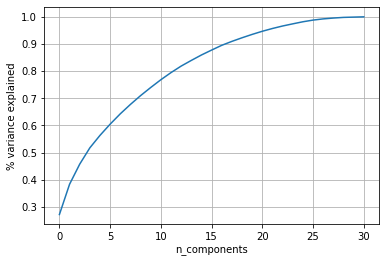

In [1341]:
from sklearn.decomposition import PCA
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [1342]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 12)
principalComponents = pca.fit_transform(x)

In [1343]:
principalComponents.size

16908

In [1344]:
principalDf = pd.DataFrame(data = principalComponents)

In [1345]:
principalDf

,0,1,2,3,4,5,6,7,8,9,10,11
0,-6.059196,1.848681,2.555410,-1.690458,1.327291,1.947139,1.838026,-0.444328,-0.562415,-0.913433,-0.553806,0.920595
1,-6.175223,1.818183,2.462759,-1.650433,1.402991,2.037912,1.966525,-0.453265,-0.628157,-0.728632,-0.503903,0.908588
2,-6.245635,1.796276,2.380559,-1.621567,1.455263,2.101001,2.063052,-0.503588,-0.681976,-0.551057,-0.481716,0.906105
3,-6.192156,1.761955,2.426889,-1.583237,1.490664,2.006268,1.903428,-0.477058,-0.644649,-0.663613,-0.457926,0.946116
4,-5.652035,1.035840,2.102762,-1.684427,1.599204,1.144164,0.918199,-0.350139,-0.572082,-1.119813,-0.652792,0.665251
...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1.665462,0.255864,-2.010258,0.113535,1.299222,-0.843552,-1.068436,0.288370,-0.669817,-0.007512,0.240508,0.170712
1405,2.209592,-0.045296,-1.656904,0.257039,1.161494,-1.142844,-1.080805,-0.740573,-0.001165,0.479711,0.525110,0.807218
1406,2.449385,-0.021017,-1.696794,0.277061,1.182691,-1.001853,-0.792303,-0.758101,0.130674,0.649634,0.355574,0.867234
1407,2.078979,0.157788,-1.982300,0.261893,1.512359,-0.864016,-0.956886,0.635863,-0.146220,-0.004404,0.053858,0.452007


In [1346]:
principalDf['Date']=df['Date']
principalDf['R0']=df['R0']

In [1347]:
df=principalDf

In [1348]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,Date,R0
0,-6.059196,1.848681,2.555410,-1.690458,1.327291,1.947139,1.838026,-0.444328,-0.562415,-0.913433,-0.553806,0.920595,2020-03-08,0.949187
1,-6.175223,1.818183,2.462759,-1.650433,1.402991,2.037912,1.966525,-0.453265,-0.628157,-0.728632,-0.503903,0.908588,2020-03-15,0.989293
2,-6.245635,1.796276,2.380559,-1.621567,1.455263,2.101001,2.063052,-0.503588,-0.681976,-0.551057,-0.481716,0.906105,2020-03-22,1.575758
3,-6.192156,1.761955,2.426889,-1.583237,1.490664,2.006268,1.903428,-0.477058,-0.644649,-0.663613,-0.457926,0.946116,2020-03-29,1.666209
4,-5.652035,1.035840,2.102762,-1.684427,1.599204,1.144164,0.918199,-0.350139,-0.572082,-1.119813,-0.652792,0.665251,2020-04-05,0.932399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1.665462,0.255864,-2.010258,0.113535,1.299222,-0.843552,-1.068436,0.288370,-0.669817,-0.007512,0.240508,0.170712,2020-08-23,0.931008
1405,2.209592,-0.045296,-1.656904,0.257039,1.161494,-1.142844,-1.080805,-0.740573,-0.001165,0.479711,0.525110,0.807218,2020-08-30,0.915388
1406,2.449385,-0.021017,-1.696794,0.277061,1.182691,-1.001853,-0.792303,-0.758101,0.130674,0.649634,0.355574,0.867234,2020-09-06,0.890198
1407,2.078979,0.157788,-1.982300,0.261893,1.512359,-0.864016,-0.956886,0.635863,-0.146220,-0.004404,0.053858,0.452007,2020-09-13,0.860875


date1=pd.Timestamp(2020, 3, 1)
df['mobility']=(df['retail_and_recreation']*0.5+df['transit_stations']*0.3 +df['workplaces']*0.3)
del df['retail_and_recreation']
del df['grocery_and_pharmacy']
del df['residential']
del df['transit_stations']
del df['workplaces']
del df['parks']
del df['mobility']
df['days_from_beginning']=(pd.to_datetime(df['Date'])-date1).dt.days
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
df

date1=pd.Timestamp(2020, 4, 1)
df_R0=pd.DataFrame(df[(pd.to_datetime(df['Date']) < date1)].groupby('Code', as_index=False)['R0'].mean())
df_R0.columns=['Code','R0_mean']
df = pd.merge(df, df_R0, on=["Code"], how="left")
df['R0_mean_estimate']=df['R0_prev18']*df['R0_mean']
del df['R0_mean']
del df['R0_prev18']
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
df

Text(0.5, 1.0, 'R0')

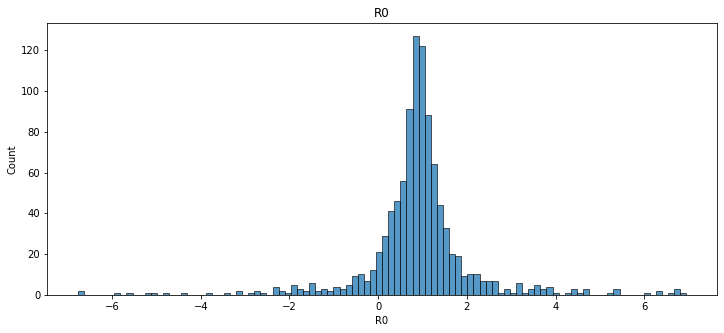

In [1349]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='R0', data=df, kde=False, bins=100, ax=axes);
axes.set_title('R0')

# Modelling and Results

pip install xgboost

In [1350]:
#Predictions from January 2021
#df=df[pd.to_datetime(df['Date']) > pd.Timestamp(2020, 5, 1)]
date1=pd.Timestamp(2021, 1, 1)

X_1=df[(pd.to_datetime(df['Date']) <= date1)]
X_2=df[(pd.to_datetime(df['Date']) > date1)]
X_train=X_1[X_1.columns[:-2]]
X_test=X_2[X_2.columns[:-2]]
y_train=X_1['R0']
y_test=X_2['R0']

In [1351]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11
0,-6.059196,1.848681,2.555410,-1.690458,1.327291,1.947139,1.838026,-0.444328,-0.562415,-0.913433,-0.553806,0.920595
1,-6.175223,1.818183,2.462759,-1.650433,1.402991,2.037912,1.966525,-0.453265,-0.628157,-0.728632,-0.503903,0.908588
2,-6.245635,1.796276,2.380559,-1.621567,1.455263,2.101001,2.063052,-0.503588,-0.681976,-0.551057,-0.481716,0.906105
3,-6.192156,1.761955,2.426889,-1.583237,1.490664,2.006268,1.903428,-0.477058,-0.644649,-0.663613,-0.457926,0.946116
4,-5.652035,1.035840,2.102762,-1.684427,1.599204,1.144164,0.918199,-0.350139,-0.572082,-1.119813,-0.652792,0.665251
...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1.665462,0.255864,-2.010258,0.113535,1.299222,-0.843552,-1.068436,0.288370,-0.669817,-0.007512,0.240508,0.170712
1405,2.209592,-0.045296,-1.656904,0.257039,1.161494,-1.142844,-1.080805,-0.740573,-0.001165,0.479711,0.525110,0.807218
1406,2.449385,-0.021017,-1.696794,0.277061,1.182691,-1.001853,-0.792303,-0.758101,0.130674,0.649634,0.355574,0.867234
1407,2.078979,0.157788,-1.982300,0.261893,1.512359,-0.864016,-0.956886,0.635863,-0.146220,-0.004404,0.053858,0.452007


## XGBoost Regressor 

### Modelling with GridSearchCV 

In [328]:
#Mape custom scoring function
def mape_fun(pred, train): 
    return np.mean(np.abs((pred - train) / train)) * 100

In [441]:
# A parameter grid for XGBoost
params = {'max_depth': [6,7,8]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(num_boost_rounds=1000) 

grid = GridSearchCV(xgb, params, verbose=1, n_jobs=-1, scoring=make_scorer(mape_fun))

In [264]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.6s finished


[16:05:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 1.66 s, sys: 170 ms, total: 1.83 s
Wall time: 11.1 s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_boost_rounds=1000,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                           

In [265]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_boost_rounds=1000,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [266]:
y_pred=grid.best_estimator_.predict(X_test)
y_pred_train=grid.best_estimator_.predict(X_train)

### XGB Evaluation

#### Test Set

In [267]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.12552133195534063
mse score is 0.026507961017687178
rmse score is 0.16281265619627724
r2 score is -1.088318154802972
mape score is 14.385696696714072


#### Train Set

In [268]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.0049989392514794345
mse score is 4.824761580558147e-05
rmse score is 0.006946050374535263
r2 score is 0.9987369573407099
mape score is 0.49179261749601744


In [269]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
47,0.908056,1.077633,0.169577
48,1.051824,1.132921,0.081097
49,1.093401,1.154729,0.061329
94,0.972591,0.964969,0.007622
95,0.851891,0.976220,0.124329
...,...,...,...
1946,0.837391,0.922971,0.085580
1947,0.856123,0.942311,0.086188
1948,0.886491,0.973571,0.087080
1949,0.917596,0.978895,0.061298


## Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

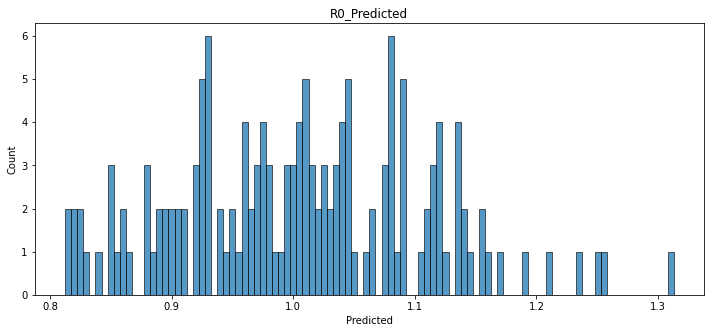

In [270]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

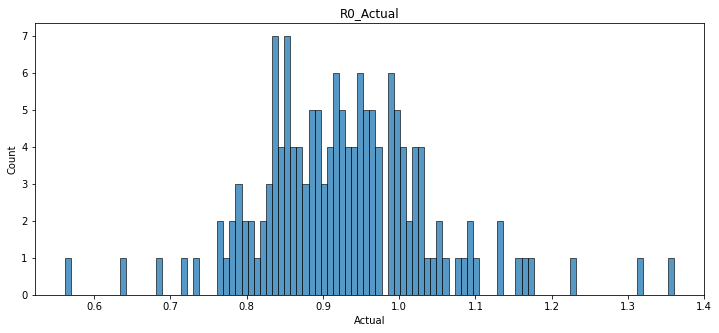

In [271]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

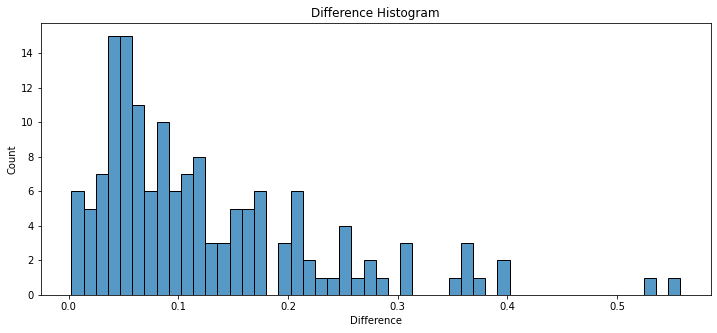

In [272]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

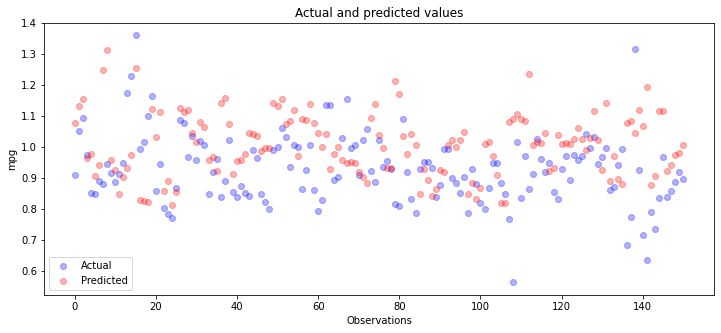

In [273]:
_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

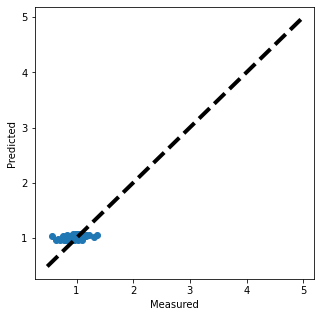

In [299]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

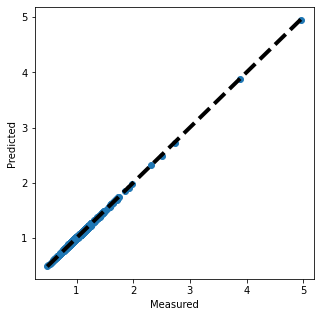

In [278]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

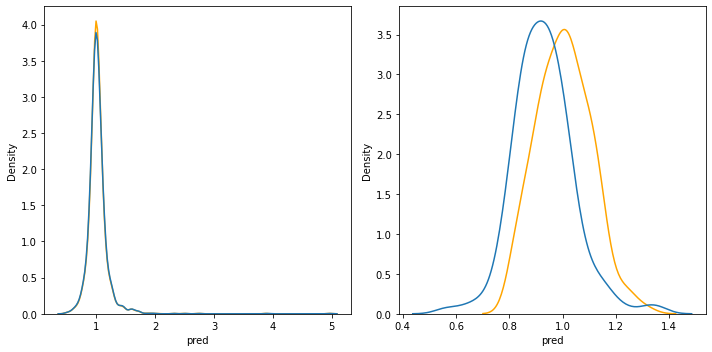

In [276]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [277]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
205,0.821511,1.098982,-0.28,0.28,-25.25
1747,1.043318,1.314996,-0.27,0.27,-20.66
157,0.974968,1.228712,-0.25,0.25,-20.65
156,0.931715,1.173939,-0.24,0.24,-20.63
204,0.825239,1.016687,-0.19,0.19,-18.83
...,...,...,...,...,...
837,1.211415,0.814759,0.40,0.40,48.68
1749,1.067035,0.713764,0.35,0.35,49.49
1701,1.076376,0.681949,0.39,0.39,57.84
1750,1.192542,0.634899,0.56,0.56,87.83


## Feature importance 

In [39]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

ValueError: tree must be Booster, XGBModel or dict instance

## Light GBM

### Modelling 

In [1352]:
params = {
    'metric': ['mae'],
    "max_depth":[8,9,10] ,
    "num_leaves": [10,20,30],  
    "max_bin": [140,150],
}

# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid = GridSearchCV(lgbm, params)

In [1353]:
%%time
grid.fit(X_train, y_train)

CPU times: user 22.4 s, sys: 534 ms, total: 22.9 s
Wall time: 6.41 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_bin': [140, 150], 'max_depth': [8, 9, 10],
                         'metric': ['mae'], 'num_leaves': [10, 20, 30]})

In [1354]:
grid.best_estimator_

LGBMRegressor(max_bin=150, max_depth=9, metric='mae', num_leaves=10)

In [1355]:
y_pred = grid.best_estimator_.predict(X_test)
y_pred_train = grid.best_estimator_.predict(X_train)

### Evaluation

#### Test Set

In [1356]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse':rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.7464354958506867
mse score is 1.2031394984746886
rmse score is 1.0968771574222378
r2 score is -0.2133235334744612
mape score is 337.9129406800573


#### Train Set

In [1357]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.5233065689874423
mse score is 0.6928395907832541
rmse score is 0.8323698641729252
r2 score is 0.6068861666742998
mape score is inf


In [1358]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
89,0.679088,1.093085,0.413997
90,0.531956,1.466341,0.934384
91,0.660194,0.720199,0.060005
92,2.270221,0.794396,1.475825
93,0.931984,0.678980,0.253004
...,...,...,...
1375,1.080372,0.936190,0.144181
1376,0.922243,1.229976,0.307733
1377,0.744629,1.084996,0.340367
1378,0.657594,1.347250,0.689656


## Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

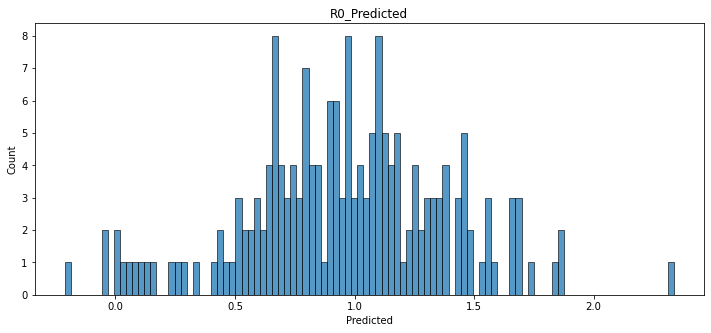

In [1359]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

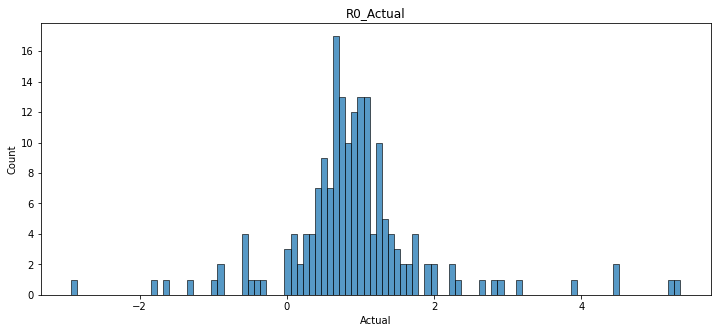

In [1360]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

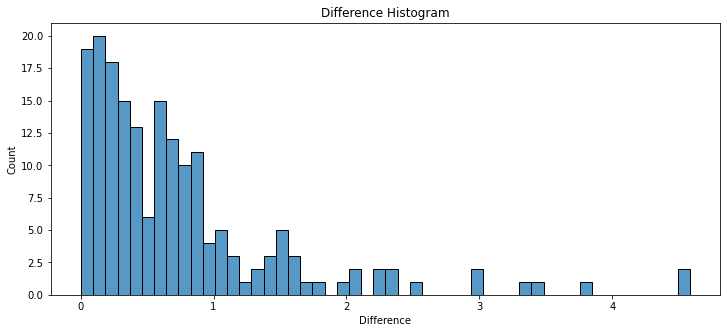

In [1361]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

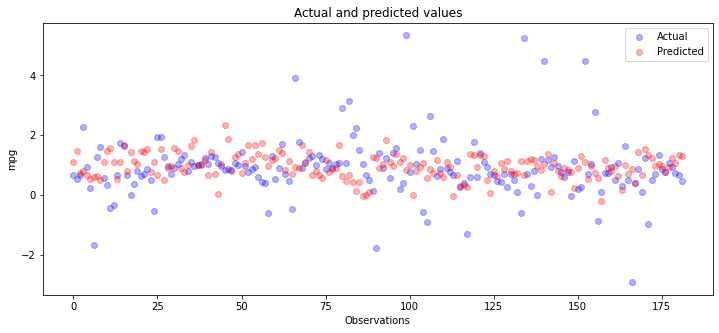

In [1362]:
_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

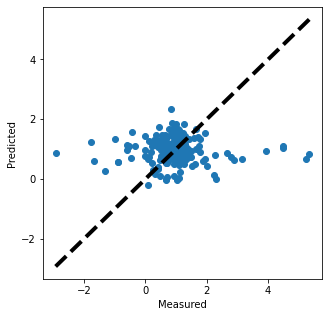

In [1363]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

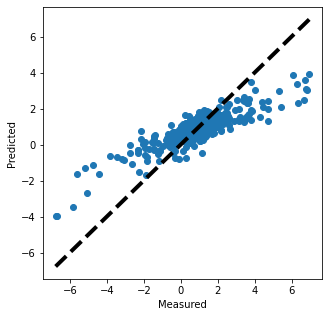

In [1364]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [1365]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11
0,-6.059196,1.848681,2.555410,-1.690458,1.327291,1.947139,1.838026,-0.444328,-0.562415,-0.913433,-0.553806,0.920595
1,-6.175223,1.818183,2.462759,-1.650433,1.402991,2.037912,1.966525,-0.453265,-0.628157,-0.728632,-0.503903,0.908588
2,-6.245635,1.796276,2.380559,-1.621567,1.455263,2.101001,2.063052,-0.503588,-0.681976,-0.551057,-0.481716,0.906105
3,-6.192156,1.761955,2.426889,-1.583237,1.490664,2.006268,1.903428,-0.477058,-0.644649,-0.663613,-0.457926,0.946116
4,-5.652035,1.035840,2.102762,-1.684427,1.599204,1.144164,0.918199,-0.350139,-0.572082,-1.119813,-0.652792,0.665251
...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1.665462,0.255864,-2.010258,0.113535,1.299222,-0.843552,-1.068436,0.288370,-0.669817,-0.007512,0.240508,0.170712
1405,2.209592,-0.045296,-1.656904,0.257039,1.161494,-1.142844,-1.080805,-0.740573,-0.001165,0.479711,0.525110,0.807218
1406,2.449385,-0.021017,-1.696794,0.277061,1.182691,-1.001853,-0.792303,-0.758101,0.130674,0.649634,0.355574,0.867234
1407,2.078979,0.157788,-1.982300,0.261893,1.512359,-0.864016,-0.956886,0.635863,-0.146220,-0.004404,0.053858,0.452007


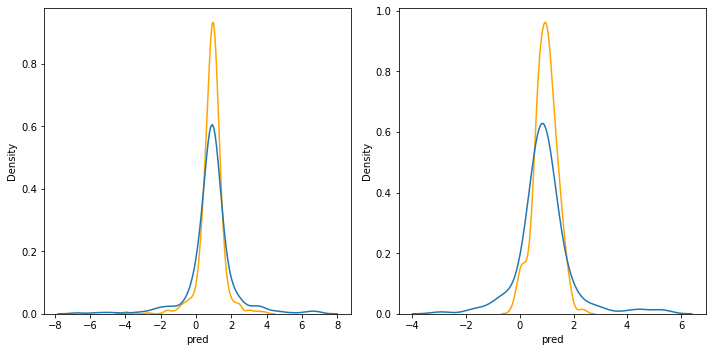

In [1366]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [1374]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
1072,0.973141,-0.003030,0.98,0.98,-32213.64
199,1.441146,-0.014794,1.46,1.46,-9841.36
1128,0.783043,-0.030227,0.81,0.81,-2690.57
145,1.583937,-0.431250,2.02,2.02,-467.29
146,1.089852,-0.333333,1.42,1.42,-426.96
...,...,...,...,...,...
1173,0.910239,0.185185,0.73,0.73,391.53
721,1.119401,0.207411,0.91,0.91,439.70
1021,0.731662,0.109920,0.62,0.62,565.63
1323,0.660171,0.090465,0.57,0.57,629.76


In [1375]:
np.abs(res_df_test[res_df_test['test']>0.1]['dif%']).mean()

76.16233128834357

In [1376]:
res_df_train[res_df_train['test']>0.1].sort_values('dif%')

,pred,test,dif,dif_abs,dif%
1282,-0.723624,0.255931,-0.98,0.98,-382.74
54,-0.346776,0.131086,-0.48,0.48,-364.54
1258,-0.470121,1.128253,-1.60,1.60,-141.67
1288,-0.123417,0.296745,-0.42,0.42,-141.59
685,-0.099654,0.692841,-0.79,0.79,-114.38
...,...,...,...,...,...
1339,0.942469,0.198964,0.74,0.74,373.69
1158,0.834362,0.174185,0.66,0.66,379.01
519,0.814891,0.122371,0.69,0.69,565.92
1035,1.622888,0.206478,1.42,1.42,685.99


In [1377]:
res_df_test['pred'].describe()

count    182.000000
mean       0.957927
std        0.424250
min       -0.210914
25%        0.701570
50%        0.965269
75%        1.229287
max        2.334776
Name: pred, dtype: float64

In [1378]:
res_df_test['test'].describe()

count    182.000000
mean       0.908589
std        0.998541
min       -2.927039
25%        0.517040
50%        0.862752
75%        1.213932
max        5.340426
Name: test, dtype: float64

## CatBoost Regressor 

### Modelling 

In [1379]:
ctbst = CatBoostRegressor(learning_rate=0.02, eval_metric='MAPE',depth=8, has_time=True)

ctbst.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)

0:	learn: 0.4211271	test: 0.4118596	best: 0.4118596 (0)	total: 17.4ms	remaining: 17.4s
1:	learn: 0.4205116	test: 0.4121571	best: 0.4118596 (0)	total: 29.8ms	remaining: 14.9s
2:	learn: 0.4197730	test: 0.4127363	best: 0.4118596 (0)	total: 41.3ms	remaining: 13.7s
3:	learn: 0.4192505	test: 0.4125011	best: 0.4118596 (0)	total: 52.4ms	remaining: 13s
4:	learn: 0.4181016	test: 0.4127516	best: 0.4118596 (0)	total: 65.6ms	remaining: 13.1s
5:	learn: 0.4172641	test: 0.4129603	best: 0.4118596 (0)	total: 76.7ms	remaining: 12.7s
6:	learn: 0.4163487	test: 0.4124493	best: 0.4118596 (0)	total: 87.9ms	remaining: 12.5s
7:	learn: 0.4158110	test: 0.4124489	best: 0.4118596 (0)	total: 99.4ms	remaining: 12.3s
8:	learn: 0.4153669	test: 0.4131745	best: 0.4118596 (0)	total: 110ms	remaining: 12.1s
9:	learn: 0.4151071	test: 0.4129966	best: 0.4118596 (0)	total: 134ms	remaining: 13.3s
10:	learn: 0.4145654	test: 0.4134792	best: 0.4118596 (0)	total: 150ms	remaining: 13.5s
11:	learn: 0.4140030	test: 0.4144333	best: 0.41

97:	learn: 0.3729100	test: 0.4349571	best: 0.4118596 (0)	total: 1.15s	remaining: 10.6s
98:	learn: 0.3726467	test: 0.4352987	best: 0.4118596 (0)	total: 1.16s	remaining: 10.6s
99:	learn: 0.3724834	test: 0.4351486	best: 0.4118596 (0)	total: 1.17s	remaining: 10.6s
100:	learn: 0.3722669	test: 0.4353464	best: 0.4118596 (0)	total: 1.19s	remaining: 10.6s
101:	learn: 0.3720294	test: 0.4352113	best: 0.4118596 (0)	total: 1.21s	remaining: 10.7s
102:	learn: 0.3716253	test: 0.4356466	best: 0.4118596 (0)	total: 1.23s	remaining: 10.7s
103:	learn: 0.3714965	test: 0.4355478	best: 0.4118596 (0)	total: 1.25s	remaining: 10.8s
104:	learn: 0.3713543	test: 0.4352426	best: 0.4118596 (0)	total: 1.4s	remaining: 11.9s
105:	learn: 0.3712667	test: 0.4356294	best: 0.4118596 (0)	total: 1.46s	remaining: 12.3s
106:	learn: 0.3710726	test: 0.4357988	best: 0.4118596 (0)	total: 1.48s	remaining: 12.4s
107:	learn: 0.3706279	test: 0.4359631	best: 0.4118596 (0)	total: 1.5s	remaining: 12.4s
108:	learn: 0.3701629	test: 0.4368878

198:	learn: 0.3411703	test: 0.4457051	best: 0.4118596 (0)	total: 3.08s	remaining: 12.4s
199:	learn: 0.3411426	test: 0.4457656	best: 0.4118596 (0)	total: 3.12s	remaining: 12.5s
200:	learn: 0.3408186	test: 0.4458563	best: 0.4118596 (0)	total: 3.14s	remaining: 12.5s
201:	learn: 0.3406667	test: 0.4459025	best: 0.4118596 (0)	total: 3.15s	remaining: 12.4s
202:	learn: 0.3405171	test: 0.4461403	best: 0.4118596 (0)	total: 3.16s	remaining: 12.4s
203:	learn: 0.3403561	test: 0.4466682	best: 0.4118596 (0)	total: 3.17s	remaining: 12.4s
204:	learn: 0.3399977	test: 0.4469233	best: 0.4118596 (0)	total: 3.18s	remaining: 12.3s
205:	learn: 0.3399143	test: 0.4472766	best: 0.4118596 (0)	total: 3.21s	remaining: 12.4s
206:	learn: 0.3397732	test: 0.4475310	best: 0.4118596 (0)	total: 3.23s	remaining: 12.4s
207:	learn: 0.3396035	test: 0.4476828	best: 0.4118596 (0)	total: 3.24s	remaining: 12.3s
208:	learn: 0.3394140	test: 0.4477119	best: 0.4118596 (0)	total: 3.27s	remaining: 12.4s
209:	learn: 0.3392028	test: 0.44

294:	learn: 0.3206445	test: 0.4591041	best: 0.4118596 (0)	total: 4.29s	remaining: 10.3s
295:	learn: 0.3204685	test: 0.4595150	best: 0.4118596 (0)	total: 4.3s	remaining: 10.2s
296:	learn: 0.3201641	test: 0.4595693	best: 0.4118596 (0)	total: 4.31s	remaining: 10.2s
297:	learn: 0.3200311	test: 0.4600767	best: 0.4118596 (0)	total: 4.32s	remaining: 10.2s
298:	learn: 0.3198738	test: 0.4603346	best: 0.4118596 (0)	total: 4.33s	remaining: 10.2s
299:	learn: 0.3197652	test: 0.4604084	best: 0.4118596 (0)	total: 4.34s	remaining: 10.1s
300:	learn: 0.3195585	test: 0.4604173	best: 0.4118596 (0)	total: 4.35s	remaining: 10.1s
301:	learn: 0.3191887	test: 0.4607117	best: 0.4118596 (0)	total: 4.36s	remaining: 10.1s
302:	learn: 0.3190323	test: 0.4607435	best: 0.4118596 (0)	total: 4.36s	remaining: 10s
303:	learn: 0.3188402	test: 0.4609455	best: 0.4118596 (0)	total: 4.37s	remaining: 10s
304:	learn: 0.3185725	test: 0.4606043	best: 0.4118596 (0)	total: 4.38s	remaining: 9.98s
305:	learn: 0.3183362	test: 0.4608796

391:	learn: 0.3021573	test: 0.4670036	best: 0.4118596 (0)	total: 5.5s	remaining: 8.54s
392:	learn: 0.3016030	test: 0.4670055	best: 0.4118596 (0)	total: 5.52s	remaining: 8.52s
393:	learn: 0.3014964	test: 0.4669580	best: 0.4118596 (0)	total: 5.53s	remaining: 8.51s
394:	learn: 0.3010480	test: 0.4671471	best: 0.4118596 (0)	total: 5.54s	remaining: 8.49s
395:	learn: 0.3010022	test: 0.4671135	best: 0.4118596 (0)	total: 5.56s	remaining: 8.48s
396:	learn: 0.3008247	test: 0.4669627	best: 0.4118596 (0)	total: 5.6s	remaining: 8.5s
397:	learn: 0.3006922	test: 0.4666898	best: 0.4118596 (0)	total: 5.62s	remaining: 8.5s
398:	learn: 0.3006701	test: 0.4668111	best: 0.4118596 (0)	total: 5.64s	remaining: 8.49s
399:	learn: 0.3004585	test: 0.4666919	best: 0.4118596 (0)	total: 5.66s	remaining: 8.48s
400:	learn: 0.3003932	test: 0.4669696	best: 0.4118596 (0)	total: 5.68s	remaining: 8.48s
401:	learn: 0.3002080	test: 0.4670544	best: 0.4118596 (0)	total: 5.69s	remaining: 8.46s
402:	learn: 0.3000952	test: 0.467025

486:	learn: 0.2880221	test: 0.4700298	best: 0.4118596 (0)	total: 6.75s	remaining: 7.11s
487:	learn: 0.2877082	test: 0.4701150	best: 0.4118596 (0)	total: 6.76s	remaining: 7.09s
488:	learn: 0.2876014	test: 0.4699811	best: 0.4118596 (0)	total: 6.77s	remaining: 7.08s
489:	learn: 0.2874208	test: 0.4702758	best: 0.4118596 (0)	total: 6.78s	remaining: 7.06s
490:	learn: 0.2872874	test: 0.4702080	best: 0.4118596 (0)	total: 6.79s	remaining: 7.04s
491:	learn: 0.2871930	test: 0.4702135	best: 0.4118596 (0)	total: 6.8s	remaining: 7.02s
492:	learn: 0.2871089	test: 0.4704464	best: 0.4118596 (0)	total: 6.81s	remaining: 7s
493:	learn: 0.2869146	test: 0.4705872	best: 0.4118596 (0)	total: 6.82s	remaining: 6.98s
494:	learn: 0.2866193	test: 0.4708741	best: 0.4118596 (0)	total: 6.83s	remaining: 6.96s
495:	learn: 0.2864495	test: 0.4708281	best: 0.4118596 (0)	total: 6.84s	remaining: 6.95s
496:	learn: 0.2863954	test: 0.4708817	best: 0.4118596 (0)	total: 6.84s	remaining: 6.93s
497:	learn: 0.2862447	test: 0.470946

586:	learn: 0.2726876	test: 0.4789520	best: 0.4118596 (0)	total: 8.18s	remaining: 5.75s
587:	learn: 0.2722213	test: 0.4792997	best: 0.4118596 (0)	total: 8.19s	remaining: 5.74s
588:	learn: 0.2720728	test: 0.4796111	best: 0.4118596 (0)	total: 8.22s	remaining: 5.74s
589:	learn: 0.2720023	test: 0.4796991	best: 0.4118596 (0)	total: 8.23s	remaining: 5.72s
590:	learn: 0.2718375	test: 0.4797803	best: 0.4118596 (0)	total: 8.25s	remaining: 5.71s
591:	learn: 0.2716481	test: 0.4799469	best: 0.4118596 (0)	total: 8.27s	remaining: 5.7s
592:	learn: 0.2715151	test: 0.4800292	best: 0.4118596 (0)	total: 8.28s	remaining: 5.68s
593:	learn: 0.2713312	test: 0.4800538	best: 0.4118596 (0)	total: 8.28s	remaining: 5.66s
594:	learn: 0.2712521	test: 0.4800405	best: 0.4118596 (0)	total: 8.29s	remaining: 5.64s
595:	learn: 0.2710488	test: 0.4797581	best: 0.4118596 (0)	total: 8.3s	remaining: 5.63s
596:	learn: 0.2709755	test: 0.4803184	best: 0.4118596 (0)	total: 8.31s	remaining: 5.61s
597:	learn: 0.2708723	test: 0.4805

683:	learn: 0.2577675	test: 0.4856632	best: 0.4118596 (0)	total: 9.39s	remaining: 4.34s
684:	learn: 0.2575817	test: 0.4859293	best: 0.4118596 (0)	total: 9.41s	remaining: 4.33s
685:	learn: 0.2575071	test: 0.4859464	best: 0.4118596 (0)	total: 9.43s	remaining: 4.32s
686:	learn: 0.2573833	test: 0.4859272	best: 0.4118596 (0)	total: 9.44s	remaining: 4.3s
687:	learn: 0.2572646	test: 0.4859990	best: 0.4118596 (0)	total: 9.45s	remaining: 4.29s
688:	learn: 0.2569842	test: 0.4859773	best: 0.4118596 (0)	total: 9.47s	remaining: 4.28s
689:	learn: 0.2569032	test: 0.4859077	best: 0.4118596 (0)	total: 9.48s	remaining: 4.26s
690:	learn: 0.2568065	test: 0.4860201	best: 0.4118596 (0)	total: 9.5s	remaining: 4.25s
691:	learn: 0.2566215	test: 0.4861566	best: 0.4118596 (0)	total: 9.52s	remaining: 4.24s
692:	learn: 0.2563439	test: 0.4862048	best: 0.4118596 (0)	total: 9.53s	remaining: 4.22s
693:	learn: 0.2561708	test: 0.4862700	best: 0.4118596 (0)	total: 9.55s	remaining: 4.21s
694:	learn: 0.2560851	test: 0.4862

786:	learn: 0.2414868	test: 0.4890763	best: 0.4118596 (0)	total: 10.8s	remaining: 2.93s
787:	learn: 0.2413817	test: 0.4893115	best: 0.4118596 (0)	total: 10.8s	remaining: 2.92s
788:	learn: 0.2412727	test: 0.4892831	best: 0.4118596 (0)	total: 10.9s	remaining: 2.9s
789:	learn: 0.2411560	test: 0.4892961	best: 0.4118596 (0)	total: 10.9s	remaining: 2.89s
790:	learn: 0.2410397	test: 0.4890063	best: 0.4118596 (0)	total: 10.9s	remaining: 2.87s
791:	learn: 0.2410071	test: 0.4889146	best: 0.4118596 (0)	total: 10.9s	remaining: 2.86s
792:	learn: 0.2409062	test: 0.4889084	best: 0.4118596 (0)	total: 10.9s	remaining: 2.85s
793:	learn: 0.2407952	test: 0.4889618	best: 0.4118596 (0)	total: 10.9s	remaining: 2.83s
794:	learn: 0.2407037	test: 0.4890044	best: 0.4118596 (0)	total: 10.9s	remaining: 2.82s
795:	learn: 0.2406694	test: 0.4890401	best: 0.4118596 (0)	total: 11s	remaining: 2.81s
796:	learn: 0.2406104	test: 0.4892644	best: 0.4118596 (0)	total: 11s	remaining: 2.8s
797:	learn: 0.2406035	test: 0.4893801	

883:	learn: 0.2289907	test: 0.4950129	best: 0.4118596 (0)	total: 12.2s	remaining: 1.61s
884:	learn: 0.2288995	test: 0.4952340	best: 0.4118596 (0)	total: 12.3s	remaining: 1.59s
885:	learn: 0.2288254	test: 0.4952926	best: 0.4118596 (0)	total: 12.3s	remaining: 1.58s
886:	learn: 0.2286994	test: 0.4952474	best: 0.4118596 (0)	total: 12.3s	remaining: 1.57s
887:	learn: 0.2284598	test: 0.4953996	best: 0.4118596 (0)	total: 12.3s	remaining: 1.55s
888:	learn: 0.2284127	test: 0.4953229	best: 0.4118596 (0)	total: 12.3s	remaining: 1.54s
889:	learn: 0.2283109	test: 0.4954602	best: 0.4118596 (0)	total: 12.3s	remaining: 1.53s
890:	learn: 0.2282611	test: 0.4952711	best: 0.4118596 (0)	total: 12.4s	remaining: 1.51s
891:	learn: 0.2280694	test: 0.4952267	best: 0.4118596 (0)	total: 12.4s	remaining: 1.5s
892:	learn: 0.2277756	test: 0.4952626	best: 0.4118596 (0)	total: 12.4s	remaining: 1.49s
893:	learn: 0.2276110	test: 0.4953304	best: 0.4118596 (0)	total: 12.4s	remaining: 1.47s
894:	learn: 0.2273618	test: 0.495

993:	learn: 0.2131540	test: 0.5001953	best: 0.4118596 (0)	total: 13.7s	remaining: 82.6ms
994:	learn: 0.2131280	test: 0.5002229	best: 0.4118596 (0)	total: 13.7s	remaining: 68.8ms
995:	learn: 0.2129326	test: 0.5000628	best: 0.4118596 (0)	total: 13.7s	remaining: 55ms
996:	learn: 0.2128654	test: 0.5000152	best: 0.4118596 (0)	total: 13.7s	remaining: 41.3ms
997:	learn: 0.2127297	test: 0.5000295	best: 0.4118596 (0)	total: 13.7s	remaining: 27.5ms
998:	learn: 0.2124899	test: 0.5001460	best: 0.4118596 (0)	total: 13.7s	remaining: 13.8ms
999:	learn: 0.2123389	test: 0.4999471	best: 0.4118596 (0)	total: 13.7s	remaining: 0us

bestTest = 0.4118596161
bestIteration = 0

Shrink model to first 1 iterations.


In [1380]:
y_pred = ctbst.predict(X_test)
y_pred_train = ctbst.predict(X_train)

### Evaluation

#### Test Set

In [1381]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.604720566576318
mse score is 0.9924891670156053
rmse score is 0.9962375053247119
r2 score is -0.0008901416545361585
mape score is 291.35045667505824


#### Train Set

In [1382]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.7366113625227115
mse score is 1.7510674349335027
rmse score is 1.3232790465104112
r2 score is 0.00645280535959214
mape score is inf


In [1383]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
89,0.679088,0.896401,0.217313
90,0.531956,0.886723,0.354767
91,0.660194,0.896329,0.236135
92,2.270221,0.896711,1.373510
93,0.931984,0.905538,0.026446
...,...,...,...
1375,1.080372,0.898551,0.181821
1376,0.922243,0.898551,0.023692
1377,0.744629,0.898551,0.153921
1378,0.657594,0.898299,0.240705


### Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

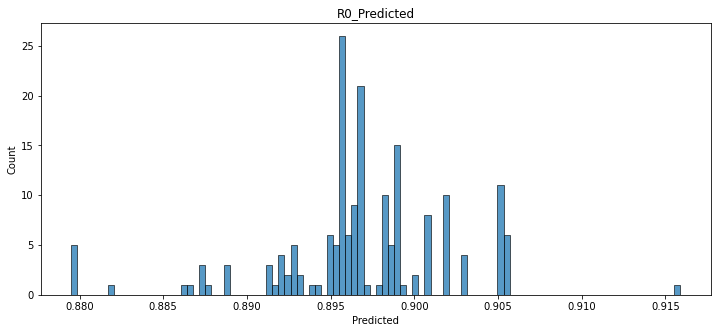

In [1384]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

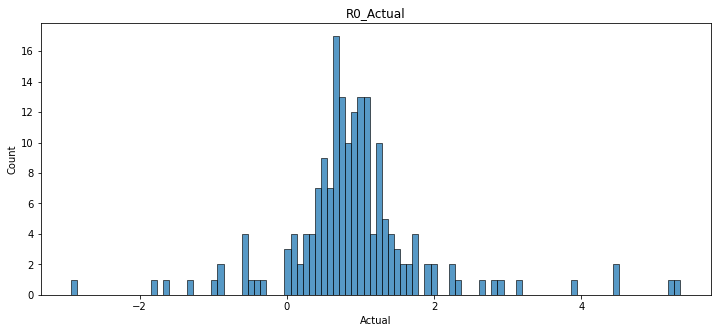

In [1385]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

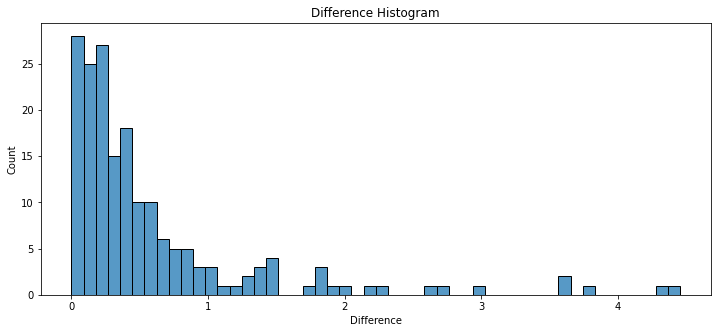

In [1386]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

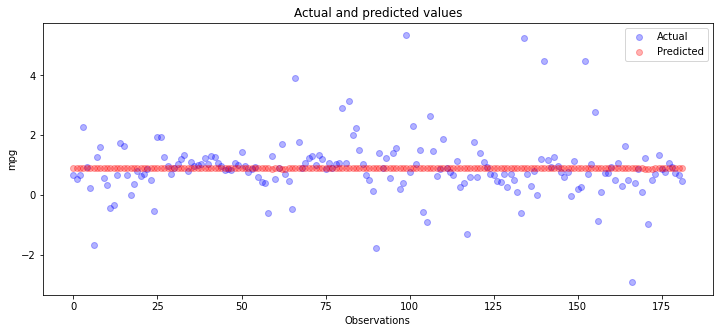

In [1387]:
_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

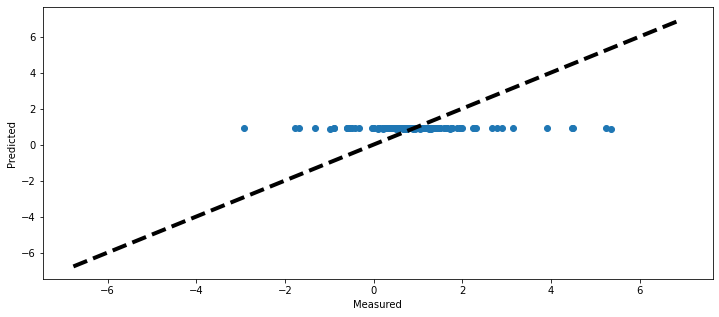

In [1388]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

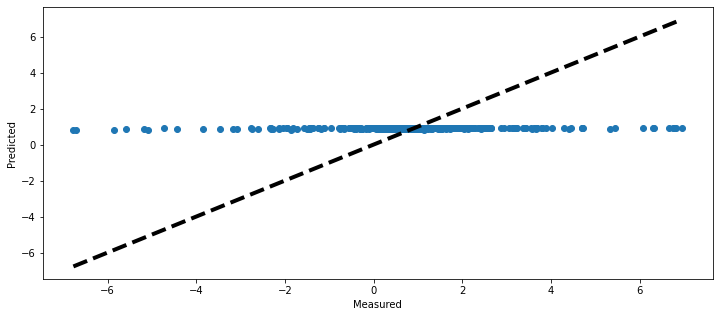

In [1389]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

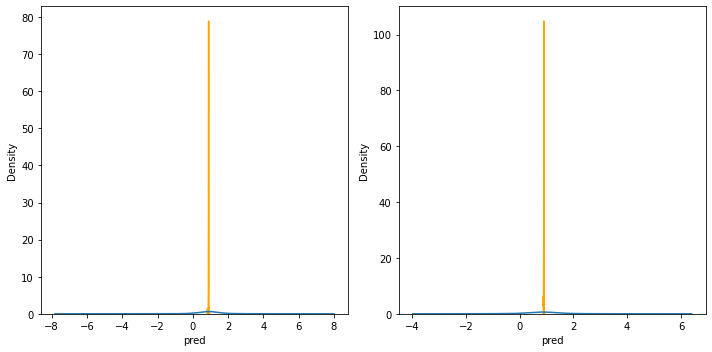

In [1390]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [1391]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
1072,0.898810,-0.003030,0.90,0.90,-29760.73
199,0.895251,-0.014794,0.91,0.91,-6151.41
1128,0.901887,-0.030227,0.93,0.93,-3083.74
146,0.898299,-0.333333,1.23,1.23,-369.49
145,0.898299,-0.431250,1.33,1.33,-308.30
...,...,...,...,...,...
1173,0.896044,0.185185,0.71,0.71,383.86
670,0.894826,0.127396,0.77,0.77,602.40
1021,0.905257,0.109920,0.80,0.80,723.56
1229,0.888713,0.098240,0.79,0.79,804.63


ValueError: shape mismatch: objects cannot be broadcast to a single shape

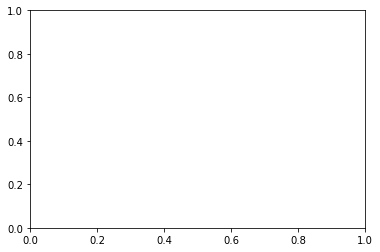

In [1392]:
sorted_feature_importance = ctbst.feature_importances_.argsort()
plt.barh(df[df.columns[2:-1]].columns, 
        ctbst.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

IndexError: index 11 is out of bounds for axis 0 with size 11

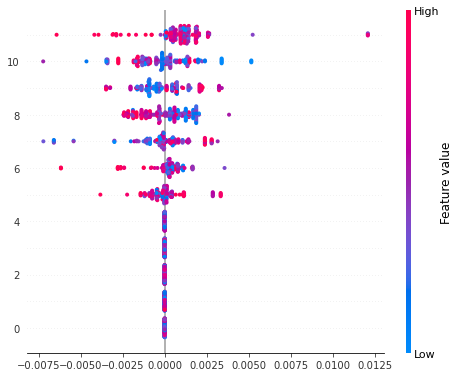

In [1393]:
explainer = shap.TreeExplainer(ctbst)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = df[df.columns[2:-1]].columns)

## Cross Validation

In [1279]:
aux=df.copy()
aux=aux.sort_values('Date')
X=aux[aux.columns[2:-1]]
y=aux[aux.columns[-1]]

In [372]:
k = 4
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    ctbst.fit(X_train, y_train)
    pred_values = ctbst.predict(X_test)
     
    acc = np.mean(np.abs((y_test - pred_values) / y_test)) * 100
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

0:	learn: 0.0928692	total: 17.8ms	remaining: 17.8s
1:	learn: 0.0927808	total: 33ms	remaining: 16.5s
2:	learn: 0.0926898	total: 49.9ms	remaining: 16.6s
3:	learn: 0.0926690	total: 61.2ms	remaining: 15.2s
4:	learn: 0.0926096	total: 83.7ms	remaining: 16.7s
5:	learn: 0.0925672	total: 92.7ms	remaining: 15.4s
6:	learn: 0.0925076	total: 101ms	remaining: 14.4s
7:	learn: 0.0924402	total: 111ms	remaining: 13.7s
8:	learn: 0.0923983	total: 119ms	remaining: 13.1s
9:	learn: 0.0923206	total: 133ms	remaining: 13.2s
10:	learn: 0.0922413	total: 147ms	remaining: 13.2s
11:	learn: 0.0921983	total: 160ms	remaining: 13.2s
12:	learn: 0.0921472	total: 173ms	remaining: 13.1s
13:	learn: 0.0920926	total: 186ms	remaining: 13.1s
14:	learn: 0.0920566	total: 199ms	remaining: 13.1s
15:	learn: 0.0919925	total: 210ms	remaining: 12.9s
16:	learn: 0.0919365	total: 240ms	remaining: 13.9s
17:	learn: 0.0918975	total: 258ms	remaining: 14.1s
18:	learn: 0.0918720	total: 271ms	remaining: 14s
19:	learn: 0.0918079	total: 288ms	remai

166:	learn: 0.0873629	total: 2.17s	remaining: 10.8s
167:	learn: 0.0873025	total: 2.18s	remaining: 10.8s
168:	learn: 0.0872997	total: 2.2s	remaining: 10.8s
169:	learn: 0.0872786	total: 2.22s	remaining: 10.8s
170:	learn: 0.0872208	total: 2.23s	remaining: 10.8s
171:	learn: 0.0871919	total: 2.25s	remaining: 10.8s
172:	learn: 0.0871751	total: 2.27s	remaining: 10.8s
173:	learn: 0.0871680	total: 2.28s	remaining: 10.8s
174:	learn: 0.0871426	total: 2.3s	remaining: 10.8s
175:	learn: 0.0870923	total: 2.31s	remaining: 10.8s
176:	learn: 0.0870734	total: 2.32s	remaining: 10.8s
177:	learn: 0.0870678	total: 2.33s	remaining: 10.8s
178:	learn: 0.0870405	total: 2.34s	remaining: 10.7s
179:	learn: 0.0870445	total: 2.35s	remaining: 10.7s
180:	learn: 0.0870334	total: 2.36s	remaining: 10.7s
181:	learn: 0.0870345	total: 2.37s	remaining: 10.6s
182:	learn: 0.0870171	total: 2.38s	remaining: 10.6s
183:	learn: 0.0869906	total: 2.39s	remaining: 10.6s
184:	learn: 0.0869361	total: 2.4s	remaining: 10.6s
185:	learn: 0.0

335:	learn: 0.0821901	total: 3.97s	remaining: 7.84s
336:	learn: 0.0821690	total: 3.98s	remaining: 7.84s
337:	learn: 0.0821394	total: 4s	remaining: 7.83s
338:	learn: 0.0820678	total: 4.01s	remaining: 7.82s
339:	learn: 0.0820403	total: 4.02s	remaining: 7.8s
340:	learn: 0.0819924	total: 4.04s	remaining: 7.8s
341:	learn: 0.0819382	total: 4.05s	remaining: 7.79s
342:	learn: 0.0818908	total: 4.06s	remaining: 7.78s
343:	learn: 0.0818892	total: 4.08s	remaining: 7.77s
344:	learn: 0.0818680	total: 4.09s	remaining: 7.76s
345:	learn: 0.0818341	total: 4.11s	remaining: 7.77s
346:	learn: 0.0817945	total: 4.14s	remaining: 7.8s
347:	learn: 0.0817651	total: 4.17s	remaining: 7.82s
348:	learn: 0.0817385	total: 4.21s	remaining: 7.85s
349:	learn: 0.0817049	total: 4.22s	remaining: 7.84s
350:	learn: 0.0816870	total: 4.24s	remaining: 7.85s
351:	learn: 0.0816749	total: 4.27s	remaining: 7.86s
352:	learn: 0.0816392	total: 4.29s	remaining: 7.87s
353:	learn: 0.0816264	total: 4.32s	remaining: 7.88s
354:	learn: 0.0816

496:	learn: 0.0776594	total: 7.17s	remaining: 7.26s
497:	learn: 0.0776286	total: 7.19s	remaining: 7.25s
498:	learn: 0.0776085	total: 7.21s	remaining: 7.24s
499:	learn: 0.0775791	total: 7.24s	remaining: 7.24s
500:	learn: 0.0775692	total: 7.26s	remaining: 7.23s
501:	learn: 0.0775382	total: 7.27s	remaining: 7.21s
502:	learn: 0.0774993	total: 7.29s	remaining: 7.2s
503:	learn: 0.0774654	total: 7.3s	remaining: 7.18s
504:	learn: 0.0774052	total: 7.3s	remaining: 7.16s
505:	learn: 0.0773896	total: 7.31s	remaining: 7.14s
506:	learn: 0.0773603	total: 7.32s	remaining: 7.12s
507:	learn: 0.0773363	total: 7.33s	remaining: 7.1s
508:	learn: 0.0773251	total: 7.34s	remaining: 7.08s
509:	learn: 0.0773124	total: 7.35s	remaining: 7.06s
510:	learn: 0.0772935	total: 7.35s	remaining: 7.04s
511:	learn: 0.0772749	total: 7.36s	remaining: 7.02s
512:	learn: 0.0772160	total: 7.37s	remaining: 7s
513:	learn: 0.0771966	total: 7.38s	remaining: 6.98s
514:	learn: 0.0771668	total: 7.4s	remaining: 6.96s
515:	learn: 0.077132

662:	learn: 0.0719031	total: 9.01s	remaining: 4.58s
663:	learn: 0.0718902	total: 9.03s	remaining: 4.57s
664:	learn: 0.0718382	total: 9.04s	remaining: 4.56s
665:	learn: 0.0718129	total: 9.05s	remaining: 4.54s
666:	learn: 0.0717790	total: 9.06s	remaining: 4.53s
667:	learn: 0.0717072	total: 9.07s	remaining: 4.51s
668:	learn: 0.0716742	total: 9.08s	remaining: 4.49s
669:	learn: 0.0716639	total: 9.09s	remaining: 4.47s
670:	learn: 0.0716363	total: 9.09s	remaining: 4.46s
671:	learn: 0.0716127	total: 9.1s	remaining: 4.44s
672:	learn: 0.0715665	total: 9.11s	remaining: 4.42s
673:	learn: 0.0715172	total: 9.12s	remaining: 4.41s
674:	learn: 0.0714945	total: 9.12s	remaining: 4.39s
675:	learn: 0.0714799	total: 9.13s	remaining: 4.38s
676:	learn: 0.0714122	total: 9.15s	remaining: 4.36s
677:	learn: 0.0714030	total: 9.16s	remaining: 4.35s
678:	learn: 0.0713758	total: 9.16s	remaining: 4.33s
679:	learn: 0.0713554	total: 9.17s	remaining: 4.32s
680:	learn: 0.0713211	total: 9.18s	remaining: 4.3s
681:	learn: 0.

843:	learn: 0.0657513	total: 10.6s	remaining: 1.96s
844:	learn: 0.0657223	total: 10.6s	remaining: 1.95s
845:	learn: 0.0657048	total: 10.6s	remaining: 1.93s
846:	learn: 0.0656604	total: 10.6s	remaining: 1.92s
847:	learn: 0.0656383	total: 10.6s	remaining: 1.91s
848:	learn: 0.0656004	total: 10.6s	remaining: 1.89s
849:	learn: 0.0655835	total: 10.7s	remaining: 1.88s
850:	learn: 0.0655619	total: 10.7s	remaining: 1.87s
851:	learn: 0.0655099	total: 10.7s	remaining: 1.85s
852:	learn: 0.0654471	total: 10.7s	remaining: 1.84s
853:	learn: 0.0654029	total: 10.7s	remaining: 1.83s
854:	learn: 0.0653789	total: 10.7s	remaining: 1.81s
855:	learn: 0.0653754	total: 10.7s	remaining: 1.8s
856:	learn: 0.0653448	total: 10.7s	remaining: 1.79s
857:	learn: 0.0653317	total: 10.7s	remaining: 1.77s
858:	learn: 0.0653025	total: 10.7s	remaining: 1.76s
859:	learn: 0.0652954	total: 10.7s	remaining: 1.75s
860:	learn: 0.0652692	total: 10.7s	remaining: 1.73s
861:	learn: 0.0652265	total: 10.7s	remaining: 1.72s
862:	learn: 0

25:	learn: 0.0872887	total: 207ms	remaining: 7.77s
26:	learn: 0.0871977	total: 221ms	remaining: 7.95s
27:	learn: 0.0870925	total: 235ms	remaining: 8.14s
28:	learn: 0.0870072	total: 246ms	remaining: 8.23s
29:	learn: 0.0869529	total: 256ms	remaining: 8.29s
30:	learn: 0.0868847	total: 265ms	remaining: 8.27s
31:	learn: 0.0868126	total: 273ms	remaining: 8.24s
32:	learn: 0.0867317	total: 280ms	remaining: 8.2s
33:	learn: 0.0866720	total: 287ms	remaining: 8.15s
34:	learn: 0.0866289	total: 294ms	remaining: 8.11s
35:	learn: 0.0865601	total: 302ms	remaining: 8.08s
36:	learn: 0.0865028	total: 309ms	remaining: 8.03s
37:	learn: 0.0864398	total: 316ms	remaining: 8s
38:	learn: 0.0863860	total: 323ms	remaining: 7.96s
39:	learn: 0.0863416	total: 330ms	remaining: 7.93s
40:	learn: 0.0862569	total: 338ms	remaining: 7.9s
41:	learn: 0.0861873	total: 345ms	remaining: 7.87s
42:	learn: 0.0861506	total: 352ms	remaining: 7.83s
43:	learn: 0.0860869	total: 359ms	remaining: 7.8s
44:	learn: 0.0860081	total: 366ms	rem

190:	learn: 0.0785417	total: 1.61s	remaining: 6.81s
191:	learn: 0.0785105	total: 1.62s	remaining: 6.82s
192:	learn: 0.0784540	total: 1.63s	remaining: 6.83s
193:	learn: 0.0784293	total: 1.64s	remaining: 6.83s
194:	learn: 0.0784006	total: 1.65s	remaining: 6.82s
195:	learn: 0.0783850	total: 1.66s	remaining: 6.81s
196:	learn: 0.0783315	total: 1.67s	remaining: 6.79s
197:	learn: 0.0782619	total: 1.67s	remaining: 6.78s
198:	learn: 0.0782110	total: 1.68s	remaining: 6.77s
199:	learn: 0.0781850	total: 1.69s	remaining: 6.76s
200:	learn: 0.0781426	total: 1.7s	remaining: 6.76s
201:	learn: 0.0780733	total: 1.71s	remaining: 6.75s
202:	learn: 0.0780332	total: 1.72s	remaining: 6.74s
203:	learn: 0.0779850	total: 1.72s	remaining: 6.73s
204:	learn: 0.0779403	total: 1.73s	remaining: 6.71s
205:	learn: 0.0778754	total: 1.74s	remaining: 6.7s
206:	learn: 0.0778297	total: 1.75s	remaining: 6.69s
207:	learn: 0.0777790	total: 1.75s	remaining: 6.68s
208:	learn: 0.0777309	total: 1.76s	remaining: 6.67s
209:	learn: 0.

359:	learn: 0.0715815	total: 2.99s	remaining: 5.31s
360:	learn: 0.0715450	total: 3.01s	remaining: 5.33s
361:	learn: 0.0715084	total: 3.02s	remaining: 5.33s
362:	learn: 0.0714847	total: 3.03s	remaining: 5.32s
363:	learn: 0.0714675	total: 3.04s	remaining: 5.31s
364:	learn: 0.0714390	total: 3.05s	remaining: 5.3s
365:	learn: 0.0714175	total: 3.05s	remaining: 5.29s
366:	learn: 0.0714042	total: 3.06s	remaining: 5.28s
367:	learn: 0.0713733	total: 3.07s	remaining: 5.27s
368:	learn: 0.0713501	total: 3.08s	remaining: 5.26s
369:	learn: 0.0713330	total: 3.08s	remaining: 5.25s
370:	learn: 0.0712936	total: 3.09s	remaining: 5.24s
371:	learn: 0.0712716	total: 3.1s	remaining: 5.23s
372:	learn: 0.0712402	total: 3.1s	remaining: 5.22s
373:	learn: 0.0712288	total: 3.11s	remaining: 5.21s
374:	learn: 0.0711997	total: 3.12s	remaining: 5.2s
375:	learn: 0.0711589	total: 3.13s	remaining: 5.19s
376:	learn: 0.0711313	total: 3.14s	remaining: 5.18s
377:	learn: 0.0711091	total: 3.14s	remaining: 5.17s
378:	learn: 0.07

530:	learn: 0.0654580	total: 4.4s	remaining: 3.88s
531:	learn: 0.0654172	total: 4.41s	remaining: 3.88s
532:	learn: 0.0653917	total: 4.43s	remaining: 3.88s
533:	learn: 0.0653388	total: 4.44s	remaining: 3.87s
534:	learn: 0.0653105	total: 4.45s	remaining: 3.86s
535:	learn: 0.0652783	total: 4.45s	remaining: 3.85s
536:	learn: 0.0652373	total: 4.46s	remaining: 3.85s
537:	learn: 0.0652189	total: 4.47s	remaining: 3.84s
538:	learn: 0.0651381	total: 4.47s	remaining: 3.83s
539:	learn: 0.0651252	total: 4.48s	remaining: 3.82s
540:	learn: 0.0651009	total: 4.49s	remaining: 3.81s
541:	learn: 0.0650686	total: 4.5s	remaining: 3.8s
542:	learn: 0.0650398	total: 4.51s	remaining: 3.8s
543:	learn: 0.0649986	total: 4.52s	remaining: 3.79s
544:	learn: 0.0649875	total: 4.53s	remaining: 3.78s
545:	learn: 0.0649717	total: 4.54s	remaining: 3.77s
546:	learn: 0.0649575	total: 4.54s	remaining: 3.76s
547:	learn: 0.0648800	total: 4.55s	remaining: 3.75s
548:	learn: 0.0648494	total: 4.56s	remaining: 3.75s
549:	learn: 0.06

699:	learn: 0.0596060	total: 5.79s	remaining: 2.48s
700:	learn: 0.0595284	total: 5.81s	remaining: 2.48s
701:	learn: 0.0594881	total: 5.82s	remaining: 2.47s
702:	learn: 0.0594689	total: 5.83s	remaining: 2.46s
703:	learn: 0.0594106	total: 5.84s	remaining: 2.45s
704:	learn: 0.0593917	total: 5.85s	remaining: 2.45s
705:	learn: 0.0593681	total: 5.85s	remaining: 2.44s
706:	learn: 0.0593032	total: 5.86s	remaining: 2.43s
707:	learn: 0.0592600	total: 5.87s	remaining: 2.42s
708:	learn: 0.0592149	total: 5.88s	remaining: 2.41s
709:	learn: 0.0591846	total: 5.88s	remaining: 2.4s
710:	learn: 0.0591669	total: 5.89s	remaining: 2.39s
711:	learn: 0.0591290	total: 5.9s	remaining: 2.38s
712:	learn: 0.0590667	total: 5.9s	remaining: 2.38s
713:	learn: 0.0590488	total: 5.91s	remaining: 2.37s
714:	learn: 0.0590255	total: 5.92s	remaining: 2.36s
715:	learn: 0.0590110	total: 5.93s	remaining: 2.35s
716:	learn: 0.0589809	total: 5.93s	remaining: 2.34s
717:	learn: 0.0589495	total: 5.94s	remaining: 2.33s
718:	learn: 0.0

866:	learn: 0.0545413	total: 7.19s	remaining: 1.1s
867:	learn: 0.0545136	total: 7.2s	remaining: 1.09s
868:	learn: 0.0544813	total: 7.21s	remaining: 1.09s
869:	learn: 0.0544776	total: 7.22s	remaining: 1.08s
870:	learn: 0.0544636	total: 7.23s	remaining: 1.07s
871:	learn: 0.0544246	total: 7.24s	remaining: 1.06s
872:	learn: 0.0543754	total: 7.25s	remaining: 1.05s
873:	learn: 0.0543555	total: 7.25s	remaining: 1.04s
874:	learn: 0.0543379	total: 7.26s	remaining: 1.04s
875:	learn: 0.0543298	total: 7.27s	remaining: 1.03s
876:	learn: 0.0543096	total: 7.28s	remaining: 1.02s
877:	learn: 0.0542710	total: 7.28s	remaining: 1.01s
878:	learn: 0.0542409	total: 7.29s	remaining: 1s
879:	learn: 0.0542102	total: 7.3s	remaining: 995ms
880:	learn: 0.0541792	total: 7.3s	remaining: 987ms
881:	learn: 0.0541507	total: 7.31s	remaining: 978ms
882:	learn: 0.0541238	total: 7.32s	remaining: 970ms
883:	learn: 0.0540714	total: 7.33s	remaining: 961ms
884:	learn: 0.0540599	total: 7.33s	remaining: 953ms
885:	learn: 0.05401

49:	learn: 0.0861936	total: 415ms	remaining: 7.88s
50:	learn: 0.0861283	total: 427ms	remaining: 7.95s
51:	learn: 0.0861018	total: 440ms	remaining: 8.02s
52:	learn: 0.0860891	total: 450ms	remaining: 8.04s
53:	learn: 0.0860402	total: 457ms	remaining: 8.01s
54:	learn: 0.0859618	total: 465ms	remaining: 8s
55:	learn: 0.0859301	total: 472ms	remaining: 7.96s
56:	learn: 0.0858887	total: 480ms	remaining: 7.94s
57:	learn: 0.0858647	total: 489ms	remaining: 7.94s
58:	learn: 0.0858112	total: 498ms	remaining: 7.95s
59:	learn: 0.0857614	total: 506ms	remaining: 7.92s
60:	learn: 0.0857535	total: 514ms	remaining: 7.91s
61:	learn: 0.0857340	total: 521ms	remaining: 7.88s
62:	learn: 0.0857193	total: 528ms	remaining: 7.85s
63:	learn: 0.0856783	total: 535ms	remaining: 7.82s
64:	learn: 0.0856728	total: 542ms	remaining: 7.8s
65:	learn: 0.0856405	total: 549ms	remaining: 7.77s
66:	learn: 0.0855747	total: 556ms	remaining: 7.75s
67:	learn: 0.0855170	total: 593ms	remaining: 8.13s
68:	learn: 0.0854900	total: 601ms	r

216:	learn: 0.0803518	total: 1.84s	remaining: 6.63s
217:	learn: 0.0803397	total: 1.85s	remaining: 6.64s
218:	learn: 0.0803164	total: 1.86s	remaining: 6.65s
219:	learn: 0.0802518	total: 1.88s	remaining: 6.66s
220:	learn: 0.0802397	total: 1.89s	remaining: 6.66s
221:	learn: 0.0802104	total: 1.9s	remaining: 6.64s
222:	learn: 0.0801508	total: 1.9s	remaining: 6.63s
223:	learn: 0.0801152	total: 1.91s	remaining: 6.62s
224:	learn: 0.0801045	total: 1.92s	remaining: 6.61s
225:	learn: 0.0800519	total: 1.93s	remaining: 6.61s
226:	learn: 0.0799991	total: 1.94s	remaining: 6.59s
227:	learn: 0.0799650	total: 1.94s	remaining: 6.58s
228:	learn: 0.0799069	total: 1.95s	remaining: 6.57s
229:	learn: 0.0798630	total: 1.96s	remaining: 6.56s
230:	learn: 0.0798321	total: 1.97s	remaining: 6.55s
231:	learn: 0.0798263	total: 1.97s	remaining: 6.53s
232:	learn: 0.0797642	total: 1.98s	remaining: 6.52s
233:	learn: 0.0797393	total: 1.99s	remaining: 6.51s
234:	learn: 0.0797063	total: 2s	remaining: 6.5s
235:	learn: 0.0796

397:	learn: 0.0742032	total: 3.42s	remaining: 5.18s
398:	learn: 0.0741699	total: 3.44s	remaining: 5.18s
399:	learn: 0.0741437	total: 3.45s	remaining: 5.17s
400:	learn: 0.0740943	total: 3.46s	remaining: 5.17s
401:	learn: 0.0740629	total: 3.46s	remaining: 5.16s
402:	learn: 0.0740504	total: 3.47s	remaining: 5.15s
403:	learn: 0.0740422	total: 3.48s	remaining: 5.14s
404:	learn: 0.0740124	total: 3.49s	remaining: 5.13s
405:	learn: 0.0739839	total: 3.5s	remaining: 5.12s
406:	learn: 0.0739400	total: 3.5s	remaining: 5.11s
407:	learn: 0.0739219	total: 3.51s	remaining: 5.09s
408:	learn: 0.0738936	total: 3.52s	remaining: 5.08s
409:	learn: 0.0738573	total: 3.52s	remaining: 5.07s
410:	learn: 0.0737811	total: 3.53s	remaining: 5.06s
411:	learn: 0.0737458	total: 3.54s	remaining: 5.05s
412:	learn: 0.0736552	total: 3.55s	remaining: 5.04s
413:	learn: 0.0736316	total: 3.56s	remaining: 5.03s
414:	learn: 0.0736094	total: 3.56s	remaining: 5.02s
415:	learn: 0.0735957	total: 3.57s	remaining: 5.01s
416:	learn: 0.

564:	learn: 0.0697642	total: 4.82s	remaining: 3.71s
565:	learn: 0.0697535	total: 4.84s	remaining: 3.71s
566:	learn: 0.0697454	total: 4.85s	remaining: 3.7s
567:	learn: 0.0696735	total: 4.86s	remaining: 3.69s
568:	learn: 0.0696234	total: 4.86s	remaining: 3.69s
569:	learn: 0.0696032	total: 4.87s	remaining: 3.68s
570:	learn: 0.0695886	total: 4.88s	remaining: 3.67s
571:	learn: 0.0695319	total: 4.89s	remaining: 3.66s
572:	learn: 0.0694669	total: 4.9s	remaining: 3.65s
573:	learn: 0.0694266	total: 4.91s	remaining: 3.64s
574:	learn: 0.0694169	total: 4.92s	remaining: 3.63s
575:	learn: 0.0694066	total: 4.92s	remaining: 3.62s
576:	learn: 0.0693930	total: 4.93s	remaining: 3.62s
577:	learn: 0.0693719	total: 4.94s	remaining: 3.61s
578:	learn: 0.0693656	total: 4.95s	remaining: 3.6s
579:	learn: 0.0693016	total: 4.95s	remaining: 3.59s
580:	learn: 0.0692872	total: 4.96s	remaining: 3.58s
581:	learn: 0.0692781	total: 4.97s	remaining: 3.57s
582:	learn: 0.0692706	total: 4.97s	remaining: 3.56s
583:	learn: 0.0

730:	learn: 0.0651490	total: 6.2s	remaining: 2.28s
731:	learn: 0.0651251	total: 6.21s	remaining: 2.27s
732:	learn: 0.0651090	total: 6.22s	remaining: 2.27s
733:	learn: 0.0650649	total: 6.24s	remaining: 2.26s
734:	learn: 0.0650220	total: 6.25s	remaining: 2.25s
735:	learn: 0.0650016	total: 6.25s	remaining: 2.24s
736:	learn: 0.0649899	total: 6.26s	remaining: 2.23s
737:	learn: 0.0649734	total: 6.27s	remaining: 2.23s
738:	learn: 0.0649678	total: 6.28s	remaining: 2.22s
739:	learn: 0.0649617	total: 6.29s	remaining: 2.21s
740:	learn: 0.0649433	total: 6.3s	remaining: 2.2s
741:	learn: 0.0649231	total: 6.31s	remaining: 2.19s
742:	learn: 0.0648992	total: 6.32s	remaining: 2.19s
743:	learn: 0.0648856	total: 6.33s	remaining: 2.18s
744:	learn: 0.0648627	total: 6.33s	remaining: 2.17s
745:	learn: 0.0648365	total: 6.34s	remaining: 2.16s
746:	learn: 0.0647686	total: 6.35s	remaining: 2.15s
747:	learn: 0.0647542	total: 6.35s	remaining: 2.14s
748:	learn: 0.0646985	total: 6.36s	remaining: 2.13s
749:	learn: 0.0

894:	learn: 0.0606494	total: 7.6s	remaining: 892ms
895:	learn: 0.0606157	total: 7.62s	remaining: 884ms
896:	learn: 0.0605862	total: 7.63s	remaining: 877ms
897:	learn: 0.0605541	total: 7.64s	remaining: 868ms
898:	learn: 0.0605445	total: 7.65s	remaining: 860ms
899:	learn: 0.0605338	total: 7.66s	remaining: 851ms
900:	learn: 0.0605030	total: 7.67s	remaining: 843ms
901:	learn: 0.0604641	total: 7.68s	remaining: 834ms
902:	learn: 0.0604497	total: 7.69s	remaining: 826ms
903:	learn: 0.0604337	total: 7.7s	remaining: 817ms
904:	learn: 0.0604210	total: 7.7s	remaining: 809ms
905:	learn: 0.0604144	total: 7.71s	remaining: 800ms
906:	learn: 0.0603790	total: 7.72s	remaining: 792ms
907:	learn: 0.0603569	total: 7.73s	remaining: 783ms
908:	learn: 0.0602860	total: 7.74s	remaining: 774ms
909:	learn: 0.0602321	total: 7.74s	remaining: 766ms
910:	learn: 0.0602023	total: 7.75s	remaining: 757ms
911:	learn: 0.0601428	total: 7.76s	remaining: 749ms
912:	learn: 0.0601219	total: 7.77s	remaining: 740ms
913:	learn: 0.0

78:	learn: 0.0932284	total: 606ms	remaining: 7.07s
79:	learn: 0.0931631	total: 618ms	remaining: 7.11s
80:	learn: 0.0930876	total: 630ms	remaining: 7.15s
81:	learn: 0.0930693	total: 641ms	remaining: 7.18s
82:	learn: 0.0930216	total: 649ms	remaining: 7.17s
83:	learn: 0.0929744	total: 656ms	remaining: 7.15s
84:	learn: 0.0929691	total: 664ms	remaining: 7.14s
85:	learn: 0.0929445	total: 671ms	remaining: 7.13s
86:	learn: 0.0929325	total: 678ms	remaining: 7.11s
87:	learn: 0.0928981	total: 686ms	remaining: 7.11s
88:	learn: 0.0928417	total: 694ms	remaining: 7.1s
89:	learn: 0.0928065	total: 701ms	remaining: 7.08s
90:	learn: 0.0927722	total: 709ms	remaining: 7.08s
91:	learn: 0.0927245	total: 723ms	remaining: 7.13s
92:	learn: 0.0927155	total: 733ms	remaining: 7.14s
93:	learn: 0.0926529	total: 741ms	remaining: 7.14s
94:	learn: 0.0926483	total: 748ms	remaining: 7.12s
95:	learn: 0.0925893	total: 756ms	remaining: 7.12s
96:	learn: 0.0925210	total: 763ms	remaining: 7.1s
97:	learn: 0.0924959	total: 769ms

256:	learn: 0.0865920	total: 2.02s	remaining: 5.83s
257:	learn: 0.0865541	total: 2.03s	remaining: 5.83s
258:	learn: 0.0865089	total: 2.04s	remaining: 5.84s
259:	learn: 0.0864902	total: 2.05s	remaining: 5.83s
260:	learn: 0.0864764	total: 2.06s	remaining: 5.82s
261:	learn: 0.0864238	total: 2.06s	remaining: 5.81s
262:	learn: 0.0864112	total: 2.07s	remaining: 5.8s
263:	learn: 0.0863721	total: 2.08s	remaining: 5.79s
264:	learn: 0.0863462	total: 2.08s	remaining: 5.78s
265:	learn: 0.0863214	total: 2.09s	remaining: 5.77s
266:	learn: 0.0862937	total: 2.1s	remaining: 5.76s
267:	learn: 0.0862492	total: 2.1s	remaining: 5.75s
268:	learn: 0.0861982	total: 2.12s	remaining: 5.75s
269:	learn: 0.0861312	total: 2.12s	remaining: 5.74s
270:	learn: 0.0860856	total: 2.13s	remaining: 5.73s
271:	learn: 0.0860194	total: 2.14s	remaining: 5.72s
272:	learn: 0.0859801	total: 2.14s	remaining: 5.71s
273:	learn: 0.0859565	total: 2.15s	remaining: 5.7s
274:	learn: 0.0859341	total: 2.16s	remaining: 5.69s
275:	learn: 0.08

428:	learn: 0.0804181	total: 3.39s	remaining: 4.52s
429:	learn: 0.0804087	total: 3.41s	remaining: 4.51s
430:	learn: 0.0803382	total: 3.42s	remaining: 4.51s
431:	learn: 0.0802803	total: 3.43s	remaining: 4.5s
432:	learn: 0.0802687	total: 3.43s	remaining: 4.5s
433:	learn: 0.0802542	total: 3.44s	remaining: 4.49s
434:	learn: 0.0802337	total: 3.45s	remaining: 4.48s
435:	learn: 0.0802163	total: 3.46s	remaining: 4.47s
436:	learn: 0.0801642	total: 3.46s	remaining: 4.46s
437:	learn: 0.0801085	total: 3.47s	remaining: 4.45s
438:	learn: 0.0801017	total: 3.48s	remaining: 4.44s
439:	learn: 0.0800726	total: 3.48s	remaining: 4.43s
440:	learn: 0.0800311	total: 3.49s	remaining: 4.42s
441:	learn: 0.0799870	total: 3.5s	remaining: 4.42s
442:	learn: 0.0799479	total: 3.5s	remaining: 4.41s
443:	learn: 0.0799354	total: 3.51s	remaining: 4.4s
444:	learn: 0.0798841	total: 3.52s	remaining: 4.39s
445:	learn: 0.0798651	total: 3.52s	remaining: 4.38s
446:	learn: 0.0798151	total: 3.53s	remaining: 4.37s
447:	learn: 0.079

602:	learn: 0.0749022	total: 4.78s	remaining: 3.15s
603:	learn: 0.0748862	total: 4.8s	remaining: 3.15s
604:	learn: 0.0748676	total: 4.81s	remaining: 3.14s
605:	learn: 0.0748348	total: 4.82s	remaining: 3.14s
606:	learn: 0.0748225	total: 4.83s	remaining: 3.13s
607:	learn: 0.0748136	total: 4.84s	remaining: 3.12s
608:	learn: 0.0747967	total: 4.85s	remaining: 3.11s
609:	learn: 0.0747861	total: 4.86s	remaining: 3.1s
610:	learn: 0.0747780	total: 4.86s	remaining: 3.1s
611:	learn: 0.0747723	total: 4.87s	remaining: 3.09s
612:	learn: 0.0747225	total: 4.88s	remaining: 3.08s
613:	learn: 0.0747154	total: 4.88s	remaining: 3.07s
614:	learn: 0.0746821	total: 4.89s	remaining: 3.06s
615:	learn: 0.0746414	total: 4.9s	remaining: 3.05s
616:	learn: 0.0745968	total: 4.9s	remaining: 3.04s
617:	learn: 0.0745881	total: 4.91s	remaining: 3.04s
618:	learn: 0.0745525	total: 4.92s	remaining: 3.03s
619:	learn: 0.0745379	total: 4.93s	remaining: 3.02s
620:	learn: 0.0745254	total: 4.94s	remaining: 3.01s
621:	learn: 0.074

773:	learn: 0.0695863	total: 6.17s	remaining: 1.8s
774:	learn: 0.0695623	total: 6.18s	remaining: 1.79s
775:	learn: 0.0695426	total: 6.19s	remaining: 1.79s
776:	learn: 0.0695009	total: 6.2s	remaining: 1.78s
777:	learn: 0.0694679	total: 6.21s	remaining: 1.77s
778:	learn: 0.0694305	total: 6.22s	remaining: 1.76s
779:	learn: 0.0694255	total: 6.22s	remaining: 1.75s
780:	learn: 0.0694061	total: 6.23s	remaining: 1.75s
781:	learn: 0.0693727	total: 6.24s	remaining: 1.74s
782:	learn: 0.0693485	total: 6.25s	remaining: 1.73s
783:	learn: 0.0693125	total: 6.26s	remaining: 1.72s
784:	learn: 0.0692747	total: 6.26s	remaining: 1.72s
785:	learn: 0.0692628	total: 6.27s	remaining: 1.71s
786:	learn: 0.0692575	total: 6.28s	remaining: 1.7s
787:	learn: 0.0691651	total: 6.29s	remaining: 1.69s
788:	learn: 0.0691516	total: 6.3s	remaining: 1.69s
789:	learn: 0.0691060	total: 6.31s	remaining: 1.68s
790:	learn: 0.0690955	total: 6.32s	remaining: 1.67s
791:	learn: 0.0690589	total: 6.33s	remaining: 1.66s
792:	learn: 0.06

947:	learn: 0.0640753	total: 7.57s	remaining: 415ms
948:	learn: 0.0640569	total: 7.58s	remaining: 407ms
949:	learn: 0.0639900	total: 7.59s	remaining: 400ms
950:	learn: 0.0639568	total: 7.6s	remaining: 392ms
951:	learn: 0.0639060	total: 7.61s	remaining: 384ms
952:	learn: 0.0638988	total: 7.62s	remaining: 376ms
953:	learn: 0.0638340	total: 7.62s	remaining: 368ms
954:	learn: 0.0637880	total: 7.63s	remaining: 360ms
955:	learn: 0.0637672	total: 7.64s	remaining: 352ms
956:	learn: 0.0637599	total: 7.64s	remaining: 344ms
957:	learn: 0.0637573	total: 7.65s	remaining: 335ms
958:	learn: 0.0637195	total: 7.66s	remaining: 327ms
959:	learn: 0.0636774	total: 7.67s	remaining: 319ms
960:	learn: 0.0636433	total: 7.68s	remaining: 312ms
961:	learn: 0.0635923	total: 7.68s	remaining: 303ms
962:	learn: 0.0635891	total: 7.69s	remaining: 295ms
963:	learn: 0.0635431	total: 7.7s	remaining: 287ms
964:	learn: 0.0635130	total: 7.7s	remaining: 279ms
965:	learn: 0.0634514	total: 7.71s	remaining: 271ms
966:	learn: 0.0

In [373]:
acc_score

[14.806663546890833, 11.341388966174806, 12.132040651434133, 8.88591841205156]

In [374]:
avg_acc_score

11.791502894137833

In [375]:
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,transit_stations,parks,workplaces,contact_tracing,testing_policy,international_travel_controls,...,school_closures,Holiday,temp,prcp,urban_population,total_vaccinations_per_100,deaths_prev_36,accumulated,R0_prev18,R0
0,AUS,2020-03-08,1.050000,1.722333,4.977667,-2.089000,7.927667,2.0,1.0,3.0,...,0.0,0.0,23.571259,0.106900,85.904,NaN,3286.314000,0.000762,1.010084,0.985779
1,AUS,2020-03-15,0.761714,1.510143,7.697286,-0.819857,10.567714,2.0,1.0,3.0,...,0.0,0.0,22.446137,0.134501,85.904,NaN,3230.041500,0.001320,1.011711,1.000861
2,AUS,2020-03-22,1.285714,3.367429,9.346857,0.938857,10.877857,2.0,1.0,3.0,...,0.0,0.0,21.810602,0.160434,85.904,NaN,3264.430250,0.001926,1.004788,1.022493
3,AUS,2020-03-29,0.714429,8.979571,5.448857,-2.857143,8.326571,2.0,1.0,3.0,...,0.0,0.0,21.346512,0.142010,85.904,NaN,3319.452250,0.002502,0.985779,1.071272
4,AUS,2020-04-05,-0.898000,15.163286,-1.061286,-4.959143,6.959000,2.0,1.0,3.0,...,0.0,0.0,21.176835,0.054789,85.904,NaN,2680.933175,0.002969,1.000861,1.063946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,-17.693857,-4.061286,-36.040857,-19.755143,-28.101857,1.0,3.0,3.0,...,3.0,0.0,2.886531,0.052132,82.058,0.216667,98076.329662,0.179232,1.069347,0.968071
2038,USA,2021-01-17,-22.775429,-3.979571,-38.877714,-16.653143,-42.081714,1.0,3.0,3.0,...,3.0,1.0,1.707192,0.066843,82.058,0.686667,101001.764888,0.188522,1.037051,0.949245
2039,USA,2021-01-24,-23.632714,-9.836714,-41.020286,-15.857143,-41.714143,1.0,3.0,3.0,...,3.0,1.0,2.500769,0.094533,82.058,1.415000,104454.372450,0.198645,1.028931,0.894853
2040,USA,2021-01-31,-23.979714,-11.387857,-39.571429,-22.591714,-28.999857,1.0,3.0,3.0,...,3.0,0.0,1.198128,0.038337,82.058,2.464000,104877.595312,0.206956,0.968071,0.910706
